In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
import pandas as pd
#from keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=3)


!mkdir DATA

A subdirectory or file DATA already exists.


### Define non-linear functions

In [2]:
def f(x,c=1):
    r=0
    if c==1:
        if x[0]>-25 and x[1]>-35 and x[0]+x[1] < 30:
            r=1
        if x[0]+x[1] > 50:
            r=1
    if c==2:
        if (np.sign(x[0]-0.2*x[1]))*np.cos(np.linalg.norm(x)/(1.5*np.pi))>0:
            r=1
    return r


def filename(s,TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"

### Generate Data (distribution 1 and 2)

In [3]:
# number of data
N=4000
# size of each sample
L=2
# box size
B=100

<function matplotlib.pyplot.show(close=None, block=None)>

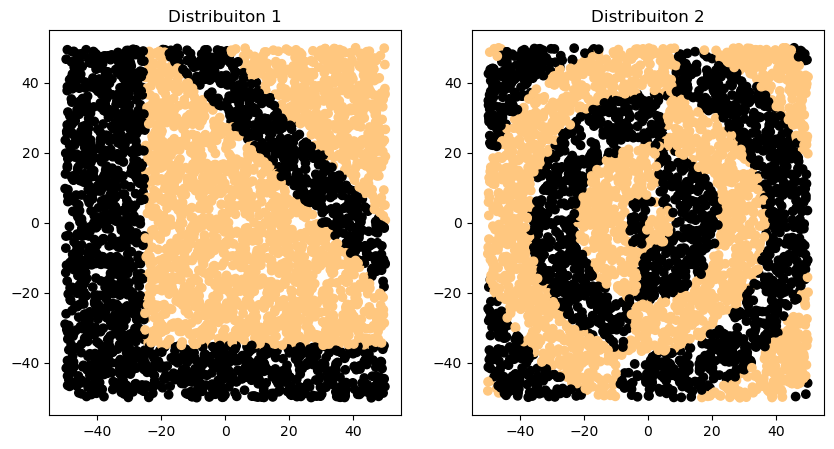

In [38]:
# random seed for reproducibility
np.random.seed(12345)

def generate_data(TYPE,N):
    x,y = (np.random.random((N,2))-0.5)*B, np.zeros(N)
    for i in range(N):
        # label data according to a nonlinear function "f"
        y[i] = f(x[i],TYPE)
    return x, y

x1, y1 = generate_data(1,N)
x2, y2 = generate_data(2,N)

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axis[0].scatter(x1[:,0],x1[:,1],c=y1,cmap=cm.copper)
axis[0].set_title("Distribuiton 1")
axis[1].scatter(x2[:,0],x2[:,1],c=y2,cmap=cm.copper)
axis[1].set_title("Distribuiton 2")

plt.show

### Generate grid

In order to predict the labels with a random data, create a grid with the same dimensions of the training set 

In [5]:
#Generate a grid of lenght 50x50 (which is the size of the raw data)
dX = 2
X1 = np.arange(-50,50+dX, dX)

LG = len(X1)
grid = np.zeros((LG*LG,2))
#print(grid)
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1

#Normalize the grid for predicting the model        
grid_r=grid/50

#### Utils

In [6]:
def split_data_training_validation(data, labels,perc_train):
    #Number of total samples for distribution 2
    N=len(data)
    #Training set
    N_train = int(perc_train * N)

    #Split training and validation set 
    (data_train, label_train) = (data[0:N_train],labels[0:N_train])
    (data_valid, label_valid) = (data[N_train:],labels[N_train:])

    return(data_train, label_train, data_valid, label_valid)

#Rescale data
def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/50

# Problem 1

### 1.1 Define DNN for distribution 1

- Create a DNN model in which the parameters that can be optimized are: optimization algorithm, activation function, network weight initialization, dropout value and number of neurons.


In [7]:
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

#Write it as a function so KerasClassifier function can work
#If not all hyperparameters will be changed, default values will be taken instead

def create_model(layers=3, optimizer="adam", activation="relu", dropout_rate=0.01, neurons = 20):
    #create model layer by layer
    model = Sequential()
    model.add(Dense(L,input_shape=(L,), activation='relu'))

    for i in range(1, layers):
        model.add(Dense(neurons, activation=activation))
        
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    # optimization method and cost function
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

### 1.2 Optimization for distribution 1

- Optimize the DNN previously defined to obtain the best accuracy. Using the x1,y1 dataset wich has 4000 samples in total from the distribution 1.

In [10]:
#Possible hyperparameters to be optimized (layers not working yet)
#batch_size = [10,25,50,75] #,100]#,100]
#epochs = [400] #[100,200,300,400]
optimizer = ["SGD", "Adagrad",  "adam",  "Nadam", "RMSprop", "Nesterov"]
activation = ["softmax",  "relu", "tanh", "sigmoid", "linear"]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#neurons = [15,20,25,30,35]
#layers=[2,3]
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero','glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

In [11]:
#create model 
model = KerasClassifier(model=create_model, 
                        batch_size=50,
                        epochs=400,
                        )

In [12]:
#Select which ones will be used in the GridSearchCV
#If batch_size or epochs is commented, then it must be written directly in the KerasClassifier
param_grid = dict(
                  #batch_size = batch_size,
                  #epochs=epochs,
                  optimizer=optimizer,
                  model__activation=activation #,
                  #model__dropout_rate= dropout_rate #it's set as 0.2 by default in create_model
                  #layers=layers
                  #model__neurons=neurons
                  #model__init_mode=init_mode
                   )

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=2)
grid_result=grid.fit(x1,y1)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Epoch 1/400
80/80 [==============================] - 2s 4ms/step - loss: 1.1441 - accuracy: 0.5813
Epoch 2/400
80/80 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6837
Epoch 3/400
80/80 [==============================] - 0s 4ms/step - loss: 0.5569 - accuracy: 0.7290
Epoch 4/400
80/80 [==============================] - 0s 4ms/step - loss: 0.5287 - accuracy: 0.7427
Epoch 5/400
80/80 [==============================] - 0s 4ms/step - loss: 0.5163 - accuracy: 0.7538
Epoch 6/400
80/80 [==============================] - 0s 4ms/step - loss: 0.4981 - accuracy: 0.7710
Epoch 7/400
80/80 [==============================] - 0s 4ms/step - loss: 0.4909 - accuracy: 0.7738
Epoch 8/400
80/80 [==============================] - 0s 4ms/step - loss: 0.4747 - accuracy: 0.7722
Epoch 9/400
80/80 [==============================] - 0s 4ms/step - loss: 0.4558 - accuracy: 0.7900
Epoch 10/400
80/80 [============================

80/80 [==============================] - 0s 4ms/step - loss: 0.2809 - accuracy: 0.8633
Epoch 83/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2855 - accuracy: 0.8643
Epoch 84/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2839 - accuracy: 0.8675
Epoch 85/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2803 - accuracy: 0.8668
Epoch 86/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2800 - accuracy: 0.8668
Epoch 87/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2816 - accuracy: 0.8637
Epoch 88/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2791 - accuracy: 0.8670
Epoch 89/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2807 - accuracy: 0.8648
Epoch 90/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2840 - accuracy: 0.8615
Epoch 91/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2848 - accuracy: 0.8618
Epoch 92/400


80/80 [==============================] - 0s 3ms/step - loss: 0.2696 - accuracy: 0.8698
Epoch 164/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2753 - accuracy: 0.8683
Epoch 165/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2729 - accuracy: 0.8702
Epoch 166/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2679 - accuracy: 0.8717
Epoch 167/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2721 - accuracy: 0.8695
Epoch 168/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2719 - accuracy: 0.8702
Epoch 169/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2770 - accuracy: 0.8673
Epoch 170/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2734 - accuracy: 0.8695
Epoch 171/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2744 - accuracy: 0.8680
Epoch 172/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2746 - accuracy: 0.8700
Epoc

80/80 [==============================] - 0s 4ms/step - loss: 0.2712 - accuracy: 0.8705
Epoch 245/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2688 - accuracy: 0.8727
Epoch 246/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2833 - accuracy: 0.8655
Epoch 247/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2715 - accuracy: 0.8695
Epoch 248/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2673 - accuracy: 0.8720
Epoch 249/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2651 - accuracy: 0.8735
Epoch 250/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2664 - accuracy: 0.8727
Epoch 251/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2662 - accuracy: 0.8735
Epoch 252/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2710 - accuracy: 0.8695
Epoch 253/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2690 - accuracy: 0.8702
Epoc

80/80 [==============================] - 0s 3ms/step - loss: 0.2647 - accuracy: 0.8748
Epoch 326/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2714 - accuracy: 0.8695
Epoch 327/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2710 - accuracy: 0.8720
Epoch 328/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2673 - accuracy: 0.8725
Epoch 329/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2668 - accuracy: 0.8720
Epoch 330/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2661 - accuracy: 0.8733
Epoch 331/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2632 - accuracy: 0.8748
Epoch 332/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2672 - accuracy: 0.8717
Epoch 333/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2640 - accuracy: 0.8742
Epoch 334/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2668 - accuracy: 0.8730
Epoc

In [13]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

result = pd.DataFrame(grid_result.cv_results_)
result = result[["param_optimizer","mean_test_score"]]
result

The best combination of hyperparameters is: {'model__activation': 'relu', 'optimizer': 'SGD'}
The accuracy obtained for those previous values is: 0.9007579855983486


,param_optimizer,mean_test_score
0,SGD,0.844765
1,Adagrad,0.830256
2,adam,0.805733
3,Nadam,0.832257
4,RMSprop,0.828518
5,Nesterov,0.854246
6,SGD,0.900758
7,Adagrad,0.890254
8,adam,0.867251
9,Nadam,0.875001


In [9]:
# 23.50 - 2023/03/09

#Select which ones will be used in the GridSearchCV
#If batch_size or epochs is commented, then it must be written directly in the KerasClassifier
param_grid = dict(
                  batch_size = batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  model__activation=activation #,
                  #model__dropout_rate= dropout_rate #it's set as 0.2 by default in create_model
                  #layers=layers
                  #model__neurons=neurons
                  #model__init_mode=init_mode
                   )

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=2)
grid_result=grid.fit(x1,y1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\fap_9\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/400
400/400 [==============================] - 2s 2ms/step - loss: 0.6790 - accuracy: 0.5782
Epoch 2/400
400/400 [==============================] - 1s 1ms/step - loss: 0.6119 - accuracy: 0.6403
Epoch 3/400
400/400 [==============================] - 1s 2ms/step - loss: 0.5815 - accuracy: 0.6560
Epoch 4/400
400/400 [==============================] - 1s 2ms/step - loss: 0.5699 - accuracy: 0.6823
Epoch 5/400
400/400 [==============================] - 1s 1ms/step - loss: 0.5621 - accuracy: 0.6845
Epoch 6/400
400/400 [==============================] - 0s 1ms/step - loss: 0.5584 - accuracy: 0.6823
Epoch 7/400
400/400 [==============================] - 0s 1ms/step - loss: 0.5538 - accuracy: 0.7005
Epoch 8/400
400/400 [==============================] - 0s 1ms/step - loss: 0.5538 - accuracy: 0.6900
Epoch 9/400
400/400 [==============================] - 0s 1ms/step - loss: 0.5509 - accuracy: 0.6930
Epoch 10/400
400/400 [==============================] - 0s 1ms/step - loss: 0.5519 - accura

400/400 [==============================] - 1s 2ms/step - loss: 0.4155 - accuracy: 0.8008
Epoch 82/400
400/400 [==============================] - 1s 2ms/step - loss: 0.4088 - accuracy: 0.8035
Epoch 83/400
400/400 [==============================] - 1s 2ms/step - loss: 0.4048 - accuracy: 0.8077
Epoch 84/400
400/400 [==============================] - 1s 2ms/step - loss: 0.3993 - accuracy: 0.8062
Epoch 85/400
400/400 [==============================] - 1s 2ms/step - loss: 0.3986 - accuracy: 0.8030
Epoch 86/400
400/400 [==============================] - 1s 2ms/step - loss: 0.3980 - accuracy: 0.8062
Epoch 87/400
400/400 [==============================] - 1s 2ms/step - loss: 0.3943 - accuracy: 0.8052
Epoch 88/400
400/400 [==============================] - 1s 1ms/step - loss: 0.3905 - accuracy: 0.8127
Epoch 89/400
400/400 [==============================] - 1s 2ms/step - loss: 0.3919 - accuracy: 0.8080
Epoch 90/400
400/400 [==============================] - 1s 1ms/step - loss: 0.3849 - accuracy: 

400/400 [==============================] - 0s 1ms/step - loss: 0.2777 - accuracy: 0.8535
Epoch 161/400
400/400 [==============================] - 1s 2ms/step - loss: 0.2754 - accuracy: 0.8525
Epoch 162/400
400/400 [==============================] - 1s 3ms/step - loss: 0.2761 - accuracy: 0.8508
Epoch 163/400
400/400 [==============================] - 1s 2ms/step - loss: 0.2743 - accuracy: 0.8530
Epoch 164/400
400/400 [==============================] - 1s 2ms/step - loss: 0.2728 - accuracy: 0.8558
Epoch 165/400
400/400 [==============================] - 1s 2ms/step - loss: 0.2731 - accuracy: 0.8562
Epoch 166/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2790 - accuracy: 0.8543
Epoch 167/400
400/400 [==============================] - 1s 2ms/step - loss: 0.2740 - accuracy: 0.8585
Epoch 168/400
400/400 [==============================] - 1s 2ms/step - loss: 0.2737 - accuracy: 0.8575
Epoch 169/400
400/400 [==============================] - 1s 2ms/step - loss: 0.2731 - a

400/400 [==============================] - 0s 1ms/step - loss: 0.2459 - accuracy: 0.8705
Epoch 240/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2537 - accuracy: 0.8608
Epoch 241/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2480 - accuracy: 0.8685
Epoch 242/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2512 - accuracy: 0.8705
Epoch 243/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2553 - accuracy: 0.8640
Epoch 244/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2505 - accuracy: 0.8708
Epoch 245/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2499 - accuracy: 0.8690
Epoch 246/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2480 - accuracy: 0.8705
Epoch 247/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2486 - accuracy: 0.8692
Epoch 248/400
400/400 [==============================] - 1s 2ms/step - loss: 0.2465 - a

400/400 [==============================] - 1s 2ms/step - loss: 0.2455 - accuracy: 0.8710
Epoch 319/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2484 - accuracy: 0.8710
Epoch 320/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2468 - accuracy: 0.8675
Epoch 321/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2430 - accuracy: 0.8758
Epoch 322/400
400/400 [==============================] - 1s 2ms/step - loss: 0.2476 - accuracy: 0.8730
Epoch 323/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2426 - accuracy: 0.8675
Epoch 324/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2455 - accuracy: 0.8725
Epoch 325/400
400/400 [==============================] - 1s 1ms/step - loss: 0.2469 - accuracy: 0.8673
Epoch 326/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2410 - accuracy: 0.8775
Epoch 327/400
400/400 [==============================] - 0s 1ms/step - loss: 0.2474 - a

400/400 [==============================] - 1s 2ms/step - loss: 0.2454 - accuracy: 0.8695
Epoch 398/400
400/400 [==============================] - 1s 2ms/step - loss: 0.2458 - accuracy: 0.8730
Epoch 399/400
400/400 [==============================] - 1s 2ms/step - loss: 0.2398 - accuracy: 0.8727
Epoch 400/400
400/400 [==============================] - 1s 1ms/step - loss: 0.2463 - accuracy: 0.8668


In [10]:
# 23.50 - 2023/03/09
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

result = pd.DataFrame(grid_result.cv_results_)
result = result[["param_optimizer","mean_test_score"]]
result

The best combination of hyperparameters is: {'batch_size': 10, 'epochs': 400, 'model__activation': 'tanh', 'optimizer': 'Nadam'}
The accuracy obtained for those previous values is: 0.9305045526749004


,param_optimizer,mean_test_score
0,SGD,0.818752
1,Adagrad,0.632029
2,Adam,0.849992
3,Nadam,0.801761
4,SGD,0.855253
...,...,...
95,Nadam,0.866249
96,SGD,0.785244
97,Adagrad,0.641260
98,Adam,0.764261


In [10]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

result = pd.DataFrame(grid_result.cv_results_)
result = result[["param_optimizer","mean_test_score"]]
result

The best combination of hyperparameters is: {'batch_size': 25, 'epochs': 300, 'optimizer': 'SGD'}
The accuracy obtained for those previous values is: 0.9060081737075949


,param_optimizer,mean_test_score
0,SGD,0.835251
1,Adagrad,0.853747
2,Adam,0.844495
3,Nadam,0.831242
4,SGD,0.853496
5,Adagrad,0.873250
6,Adam,0.842492
7,Nadam,0.866502
8,SGD,0.906008
9,Adagrad,0.835492


### 1.3 Test accuracy with distribution 1

- Separate data of distribution 1 in training and validation set

In [14]:
#Split data of distribution 1 in training and validation 
d1_train_data, d1_train_label, d1_val_data, d1_val_label = split_data_training_validation(x1, y1, 0.8)

#Normalize data
d1_train_data=Rescale(d1_train_data)
d1_val_data=Rescale(d1_val_data)

print("Train:",len(d1_train_data),"\t Validation:",len(d1_val_data))

Train: 3200 	 Validation: 800


- Test the training and validation set

In [15]:
# using the best hyperparameters
#best_parameters = {'model__activation': 'relu', 'optimizer': 'Adam'}

#params = {'batch_size': 25, 'epochs': 300, 'optimizer': 'SGD'}
#params = {'batch_size': 10, 'epochs': 400, 'model__activation': 'tanh', 'optimizer': 'Nadam'}
#params = {'model__activation': 'sigmoid', 'optimizer': 'Nadam'} #2.36 - 2023-03-10
params = {'model__activation': 'tanh', 'optimizer': 'SGD'} #4.13 - 2023-03-10
params = {'model__activation': 'relu', 'optimizer': 'SGD'}

In [16]:
model_1 = create_model(layers=3, 
                       optimizer= params['optimizer'], 
                       activation=params['model__activation'], 
                       dropout_rate=0.01, 
                       neurons = 20
                      )

# results
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2)                 6         
                                                                 
 dense_5 (Dense)             (None, 20)                60        
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________


In [28]:
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

#run model_1
final_model_dsitribution_1= model_1.fit(d1_train_data, d1_train_label,
               #epochs = 500, batch_size = 60,
               epochs = 400, batch_size = 50,                         
               validation_data=(d1_val_data, d1_val_label),
               verbose=2)

Epoch 1/400
64/64 - 1s - loss: 0.0652 - accuracy: 0.9753 - val_loss: 0.0911 - val_accuracy: 0.9650 - 690ms/epoch - 11ms/step
Epoch 2/400
64/64 - 0s - loss: 0.0595 - accuracy: 0.9756 - val_loss: 0.0742 - val_accuracy: 0.9688 - 281ms/epoch - 4ms/step
Epoch 3/400
64/64 - 0s - loss: 0.0612 - accuracy: 0.9766 - val_loss: 0.4082 - val_accuracy: 0.8938 - 305ms/epoch - 5ms/step
Epoch 4/400
64/64 - 0s - loss: 0.0611 - accuracy: 0.9772 - val_loss: 0.1749 - val_accuracy: 0.9450 - 285ms/epoch - 4ms/step
Epoch 5/400
64/64 - 0s - loss: 0.0650 - accuracy: 0.9778 - val_loss: 0.0425 - val_accuracy: 0.9875 - 276ms/epoch - 4ms/step
Epoch 6/400
64/64 - 0s - loss: 0.0632 - accuracy: 0.9778 - val_loss: 0.0471 - val_accuracy: 0.9787 - 287ms/epoch - 4ms/step
Epoch 7/400
64/64 - 0s - loss: 0.0593 - accuracy: 0.9769 - val_loss: 0.0422 - val_accuracy: 0.9850 - 281ms/epoch - 4ms/step
Epoch 8/400
64/64 - 0s - loss: 0.0642 - accuracy: 0.9750 - val_loss: 0.0394 - val_accuracy: 0.9812 - 276ms/epoch - 4ms/step
Epoch 9

Epoch 67/400
64/64 - 0s - loss: 0.0543 - accuracy: 0.9809 - val_loss: 0.0569 - val_accuracy: 0.9725 - 291ms/epoch - 5ms/step
Epoch 68/400
64/64 - 0s - loss: 0.0626 - accuracy: 0.9753 - val_loss: 0.0517 - val_accuracy: 0.9737 - 290ms/epoch - 5ms/step
Epoch 69/400
64/64 - 0s - loss: 0.0577 - accuracy: 0.9803 - val_loss: 0.0635 - val_accuracy: 0.9688 - 286ms/epoch - 4ms/step
Epoch 70/400
64/64 - 0s - loss: 0.0646 - accuracy: 0.9766 - val_loss: 0.0505 - val_accuracy: 0.9812 - 297ms/epoch - 5ms/step
Epoch 71/400
64/64 - 0s - loss: 0.0575 - accuracy: 0.9784 - val_loss: 0.0716 - val_accuracy: 0.9675 - 287ms/epoch - 4ms/step
Epoch 72/400
64/64 - 0s - loss: 0.0534 - accuracy: 0.9816 - val_loss: 0.1042 - val_accuracy: 0.9638 - 286ms/epoch - 4ms/step
Epoch 73/400
64/64 - 0s - loss: 0.0610 - accuracy: 0.9769 - val_loss: 0.0418 - val_accuracy: 0.9862 - 277ms/epoch - 4ms/step
Epoch 74/400
64/64 - 0s - loss: 0.0635 - accuracy: 0.9731 - val_loss: 0.0798 - val_accuracy: 0.9625 - 260ms/epoch - 4ms/step


Epoch 133/400
64/64 - 0s - loss: 0.0611 - accuracy: 0.9753 - val_loss: 0.0932 - val_accuracy: 0.9588 - 292ms/epoch - 5ms/step
Epoch 134/400
64/64 - 0s - loss: 0.0551 - accuracy: 0.9784 - val_loss: 0.0471 - val_accuracy: 0.9850 - 293ms/epoch - 5ms/step
Epoch 135/400
64/64 - 0s - loss: 0.0660 - accuracy: 0.9762 - val_loss: 0.0555 - val_accuracy: 0.9725 - 285ms/epoch - 4ms/step
Epoch 136/400
64/64 - 0s - loss: 0.0499 - accuracy: 0.9809 - val_loss: 0.0376 - val_accuracy: 0.9862 - 264ms/epoch - 4ms/step
Epoch 137/400
64/64 - 0s - loss: 0.0514 - accuracy: 0.9797 - val_loss: 0.0390 - val_accuracy: 0.9850 - 282ms/epoch - 4ms/step
Epoch 138/400
64/64 - 0s - loss: 0.0696 - accuracy: 0.9747 - val_loss: 0.0371 - val_accuracy: 0.9850 - 281ms/epoch - 4ms/step
Epoch 139/400
64/64 - 0s - loss: 0.0518 - accuracy: 0.9797 - val_loss: 0.0749 - val_accuracy: 0.9613 - 286ms/epoch - 4ms/step
Epoch 140/400
64/64 - 0s - loss: 0.0636 - accuracy: 0.9756 - val_loss: 0.0425 - val_accuracy: 0.9812 - 287ms/epoch - 4

64/64 - 0s - loss: 0.0555 - accuracy: 0.9762 - val_loss: 0.0315 - val_accuracy: 0.9950 - 271ms/epoch - 4ms/step
Epoch 199/400
64/64 - 0s - loss: 0.0559 - accuracy: 0.9812 - val_loss: 0.0347 - val_accuracy: 0.9912 - 303ms/epoch - 5ms/step
Epoch 200/400
64/64 - 0s - loss: 0.0595 - accuracy: 0.9762 - val_loss: 0.0521 - val_accuracy: 0.9812 - 281ms/epoch - 4ms/step
Epoch 201/400
64/64 - 0s - loss: 0.0509 - accuracy: 0.9778 - val_loss: 0.0487 - val_accuracy: 0.9800 - 255ms/epoch - 4ms/step
Epoch 202/400
64/64 - 0s - loss: 0.0528 - accuracy: 0.9803 - val_loss: 0.1000 - val_accuracy: 0.9588 - 308ms/epoch - 5ms/step
Epoch 203/400
64/64 - 0s - loss: 0.0576 - accuracy: 0.9781 - val_loss: 0.0448 - val_accuracy: 0.9750 - 277ms/epoch - 4ms/step
Epoch 204/400
64/64 - 0s - loss: 0.0480 - accuracy: 0.9841 - val_loss: 0.0593 - val_accuracy: 0.9712 - 258ms/epoch - 4ms/step
Epoch 205/400
64/64 - 0s - loss: 0.0568 - accuracy: 0.9809 - val_loss: 0.0496 - val_accuracy: 0.9825 - 240ms/epoch - 4ms/step
Epoch 

Epoch 264/400
64/64 - 0s - loss: 0.0520 - accuracy: 0.9806 - val_loss: 0.0725 - val_accuracy: 0.9725 - 260ms/epoch - 4ms/step
Epoch 265/400
64/64 - 0s - loss: 0.0547 - accuracy: 0.9819 - val_loss: 0.0524 - val_accuracy: 0.9737 - 280ms/epoch - 4ms/step
Epoch 266/400
64/64 - 0s - loss: 0.0505 - accuracy: 0.9816 - val_loss: 0.0327 - val_accuracy: 0.9900 - 272ms/epoch - 4ms/step
Epoch 267/400
64/64 - 0s - loss: 0.0560 - accuracy: 0.9769 - val_loss: 0.0508 - val_accuracy: 0.9800 - 261ms/epoch - 4ms/step
Epoch 268/400
64/64 - 0s - loss: 0.0506 - accuracy: 0.9794 - val_loss: 0.0553 - val_accuracy: 0.9700 - 279ms/epoch - 4ms/step
Epoch 269/400
64/64 - 0s - loss: 0.0545 - accuracy: 0.9756 - val_loss: 0.0311 - val_accuracy: 0.9887 - 250ms/epoch - 4ms/step
Epoch 270/400
64/64 - 0s - loss: 0.0556 - accuracy: 0.9778 - val_loss: 0.0371 - val_accuracy: 0.9850 - 257ms/epoch - 4ms/step
Epoch 271/400
64/64 - 0s - loss: 0.0490 - accuracy: 0.9816 - val_loss: 0.1177 - val_accuracy: 0.9625 - 261ms/epoch - 4

64/64 - 0s - loss: 0.0524 - accuracy: 0.9787 - val_loss: 0.0324 - val_accuracy: 0.9875 - 265ms/epoch - 4ms/step
Epoch 330/400
64/64 - 0s - loss: 0.0465 - accuracy: 0.9812 - val_loss: 0.0514 - val_accuracy: 0.9750 - 241ms/epoch - 4ms/step
Epoch 331/400
64/64 - 0s - loss: 0.0557 - accuracy: 0.9831 - val_loss: 0.0365 - val_accuracy: 0.9825 - 265ms/epoch - 4ms/step
Epoch 332/400
64/64 - 0s - loss: 0.0466 - accuracy: 0.9834 - val_loss: 0.0369 - val_accuracy: 0.9837 - 301ms/epoch - 5ms/step
Epoch 333/400
64/64 - 0s - loss: 0.0505 - accuracy: 0.9834 - val_loss: 0.0495 - val_accuracy: 0.9787 - 309ms/epoch - 5ms/step
Epoch 334/400
64/64 - 0s - loss: 0.0564 - accuracy: 0.9759 - val_loss: 0.0713 - val_accuracy: 0.9650 - 328ms/epoch - 5ms/step
Epoch 335/400
64/64 - 0s - loss: 0.0427 - accuracy: 0.9834 - val_loss: 0.0588 - val_accuracy: 0.9750 - 324ms/epoch - 5ms/step
Epoch 336/400
64/64 - 0s - loss: 0.0421 - accuracy: 0.9828 - val_loss: 0.0380 - val_accuracy: 0.9837 - 318ms/epoch - 5ms/step
Epoch 

Epoch 395/400
64/64 - 0s - loss: 0.0519 - accuracy: 0.9784 - val_loss: 0.0385 - val_accuracy: 0.9825 - 270ms/epoch - 4ms/step
Epoch 396/400
64/64 - 0s - loss: 0.0441 - accuracy: 0.9837 - val_loss: 0.0322 - val_accuracy: 0.9900 - 290ms/epoch - 5ms/step
Epoch 397/400
64/64 - 0s - loss: 0.0487 - accuracy: 0.9841 - val_loss: 0.0448 - val_accuracy: 0.9787 - 265ms/epoch - 4ms/step
Epoch 398/400
64/64 - 0s - loss: 0.0498 - accuracy: 0.9769 - val_loss: 0.0564 - val_accuracy: 0.9762 - 287ms/epoch - 4ms/step
Epoch 399/400
64/64 - 0s - loss: 0.0626 - accuracy: 0.9775 - val_loss: 0.0360 - val_accuracy: 0.9837 - 296ms/epoch - 5ms/step
Epoch 400/400
64/64 - 0s - loss: 0.0461 - accuracy: 0.9809 - val_loss: 0.0424 - val_accuracy: 0.9850 - 302ms/epoch - 5ms/step


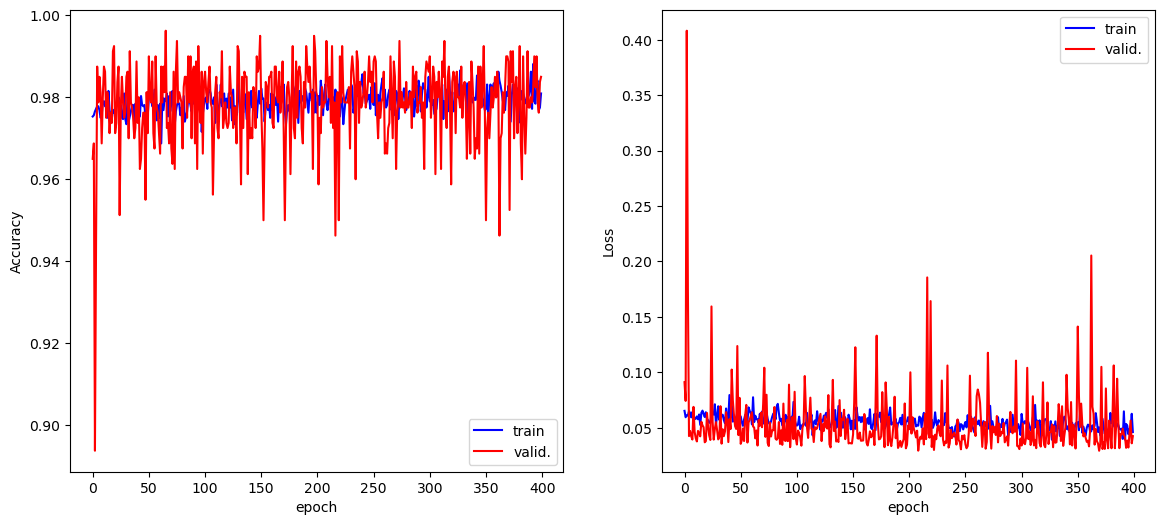

In [29]:
# plot performance

fig,AX=plt.subplots(1,2,figsize=(14,6.))

ax=AX[0]
ax.plot(final_model_dsitribution_1.history['accuracy'],label="train",c="b")
ax.plot(final_model_dsitribution_1.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()

ax=AX[1]
ax.plot(final_model_dsitribution_1.history['loss'],label="train",c="b")
ax.plot(final_model_dsitribution_1.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

82/82 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'prediction')

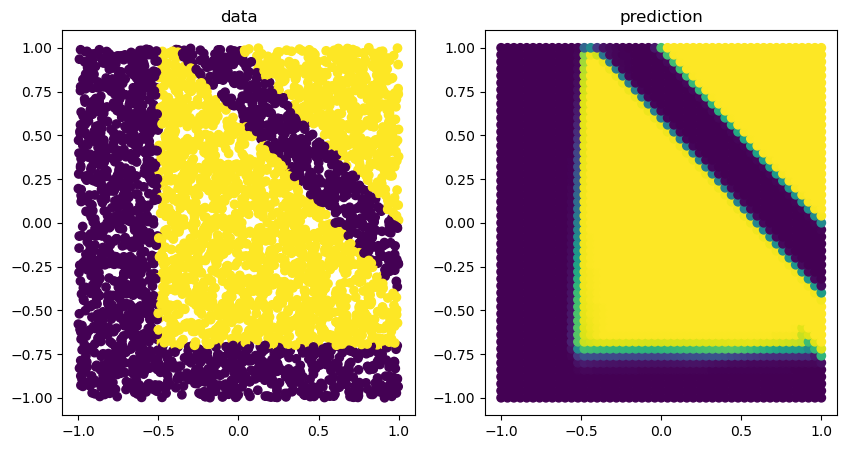

In [30]:
#Predict the possible labels of the grid created previously using the final_model_distribution 1 and plot
pred_optimized = model_1.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated with optimization
axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[1].set_title("prediction")

# Problem 2

- Using the best DNN from the previous section we study how the performance changes when the number N of samples

In [32]:
# random seed for reproducibility
np.random.seed(123456)

#split_data_training_validation(data, labels,perc_train)

#### a) decrease

In [53]:
N_a = 2000

# take from the previous training set and sample randomly 2000
permutation = np.random.permutation(x1.shape[0])

X_a = x1[permutation][:N_a]
y_a = y1[permutation][:N_a]

x1_train_a, y1_train_a, x1_val_a, y1_val_a = split_data_training_validation(X_a,y_a, 0.8)

#Normalize data
x1_train_a=Rescale(x1_train_a)
x1_val_a=Rescale(x1_val_a)

print("Train:",len(x1_train_a),"\t Validation:",len(x1_val_a))

Train: 1600 	 Validation: 400


In [55]:
#best_parameters
best_params = {'model__activation': 'relu', 'optimizer': 'SGD'}

# initialize model
model_1 = create_model(layers=3, 
                       optimizer= params['optimizer'], 
                       activation=params['model__activation'], 
                       dropout_rate=0.01, 
                       neurons = 20
                      )

# random seed for reproducibility
np.random.seed(123456+1)

# fit model
d1_model_a = model_1.fit(x1_train_a, y1_train_a,
               epochs = 500, batch_size = 60,
               validation_data=(x1_val_a, y1_val_a),
               verbose=0)

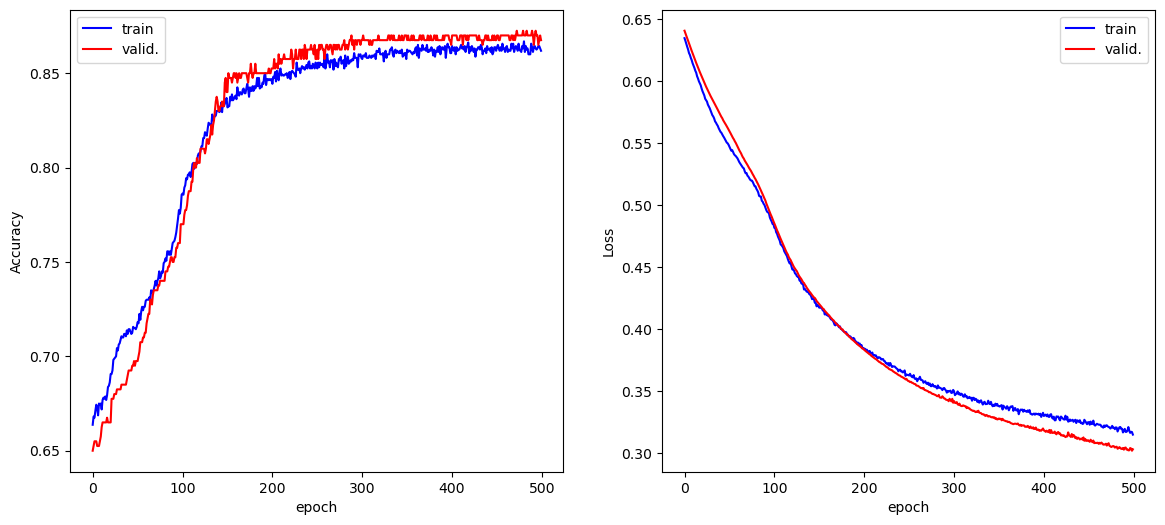

In [56]:
# plot performance

fig,AX=plt.subplots(1,2,figsize=(14,6.))
d1_model_a
ax=AX[0]
ax.plot(d1_model_a.history['accuracy'],label="train",c="b")
ax.plot(d1_model_a.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()

ax=AX[1]
ax.plot(d1_model_a.history['loss'],label="train",c="b")
ax.plot(d1_model_a.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [ ]:
#Predict the possible labels of the grid created previously using the final_model_distribution 1 and plot
pred_optimized = model_1.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated with optimization
axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[1].set_title("prediction")

#### b) increase

In [39]:
N_b = 6000
x1_b, y1_b = generate_data(1,N_b)
x1_train_b, y1_train_b, x1_val_b, y1_val_b = split_data_training_validation(x1_b, y1_b, 0.8)

#Normalize data
x1_train_b=Rescale(x1_train_b)
x1_val_b=Rescale(x1_val_b)

print("Train:",len(x1_train_b),"\t Validation:",len(x1_val_b))

Train: 4800 	 Validation: 1200


In [57]:
#best_parameters
best_params = {'model__activation': 'relu', 'optimizer': 'SGD'}

# initialize model
model_1 = create_model(layers=3, 
                       optimizer= params['optimizer'], 
                       activation=params['model__activation'], 
                       dropout_rate=0.01, 
                       neurons = 20
                      )

# random seed for reproducibility
np.random.seed(123456+2)

# fit model
d1_model_b = model_1.fit(x1_train_b, y1_train_b,
               epochs = 500, batch_size = 60,
               validation_data=(x1_val_b, y1_val_b),
               verbose=0)

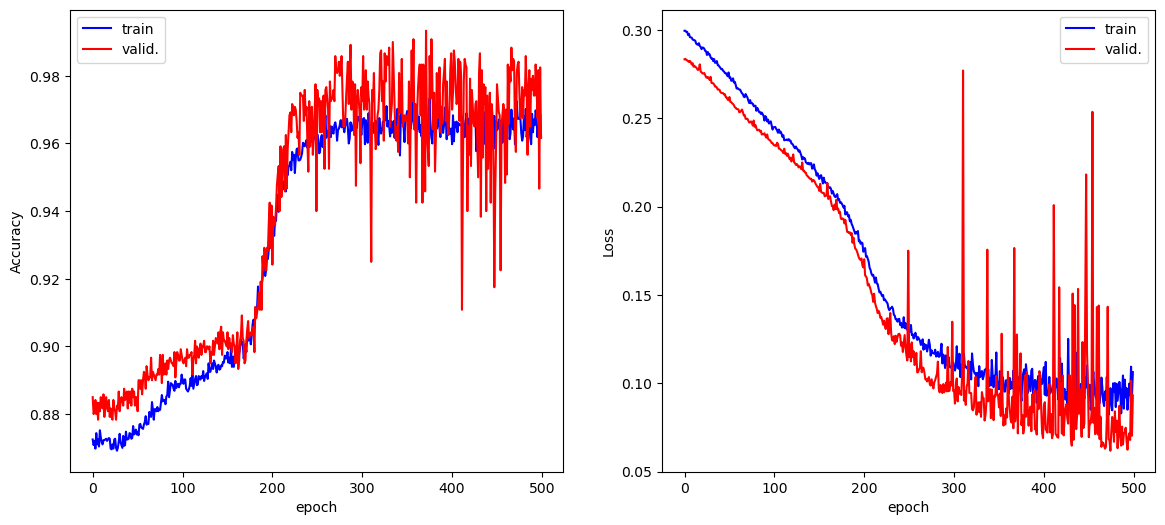

In [59]:
# plot performance

fig,AX=plt.subplots(1,2,figsize=(14,6.))

ax=AX[0]
ax.plot(d1_model_b.history['accuracy'],label="train",c="b")
ax.plot(d1_model_b.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()

ax=AX[1]
ax.plot(d1_model_b.history['loss'],label="train",c="b")
ax.plot(d1_model_b.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [ ]:
#Predict the possible labels of the grid created previously using the final_model_distribution 1 and plot
pred_optimized = model_1.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated with optimization
axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[1].set_title("prediction")

#### c) augmented

In [127]:
#N_c = 4000
#x1_c, y1_c = generate_data(1,N_c)
x1_train_c, y1_train_c, x1_val_c, y1_val_c = split_data_training_validation(x1, y1, 0.8)

# random seed for reproducibility
np.random.seed(123456+3)

# shift on training set
x1_train_c_shift = x1_train_c + np.random.normal(0,0.01,size=x1_train_c.shape)
print(x1_train_c_shift.shape)
x1_train_c = np.vstack([x1_train_c,x1_train_c_shift])
print(x1_train_c.shape)

y1_train_c_shift = y1_train_c + np.random.normal(0,0.01,size=y1_train_c.shape)
print(y1_train_c_shift.shape)
y1_train_c = np.concatenate([y1_train_c,y1_train_c_shift])
print(y1_train_c.shape)

# Shuffle the training data
shuffle_idx = np.random.permutation(len(x1_train_c))
x1_train_c = x1_train_c[shuffle_idx]
y1_train_c = y1_train_c[shuffle_idx]

#Normalize data
x1_train_c=Rescale(x1_train_c)
x1_val_c=Rescale(x1_val_c)

print("Train:",len(x1_train_c),"\t Validation:",len(x1_val_c))

(3200, 2)
(6400, 2)
(3200,)
(6400,)
Train: 6400 	 Validation: 800


In [128]:
#best_parameters
best_params = {'model__activation': 'relu', 'optimizer': 'SGD'}

# initialize model
model_1 = create_model(layers=3, 
                       optimizer= params['optimizer'], 
                       activation=params['model__activation'], 
                       dropout_rate=0.01, 
                       neurons = 20
                      )

# random seed for reproducibility
np.random.seed(123456+4)

# fit model
d1_model_c = model_1.fit(x1_train_c, y1_train_c,
               epochs = 500, batch_size = 60,
               validation_data=(x1_val_c, y1_val_c),
               verbose=0)

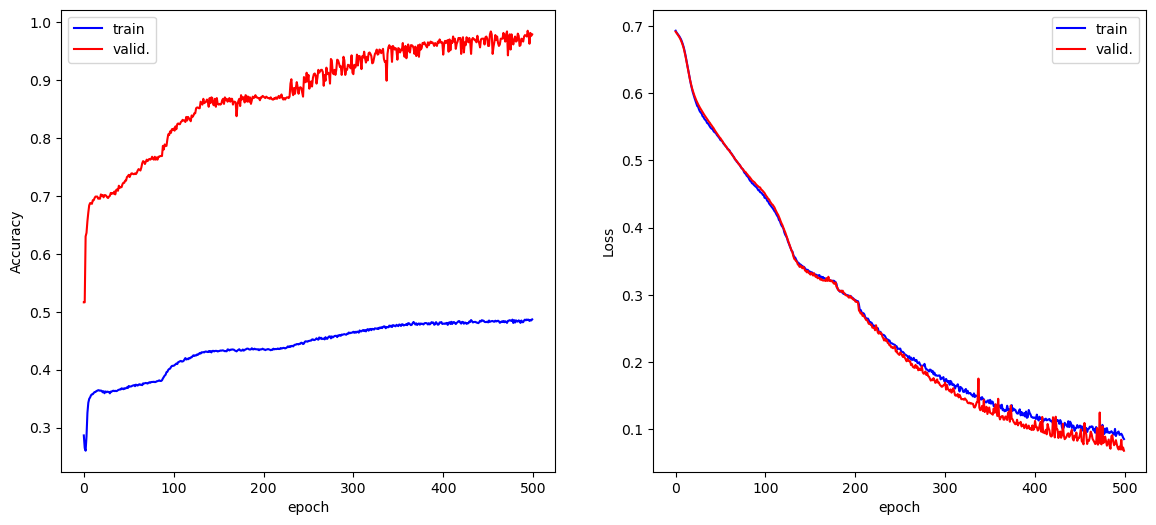

In [129]:
# plot performance

fig,AX=plt.subplots(1,2,figsize=(14,6.))

ax=AX[0]
ax.plot(d1_model_c.history['accuracy'],label="train",c="b")
ax.plot(d1_model_c.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()

ax=AX[1]
ax.plot(d1_model_c.history['loss'],label="train",c="b")
ax.plot(d1_model_c.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

82/82 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'prediction')

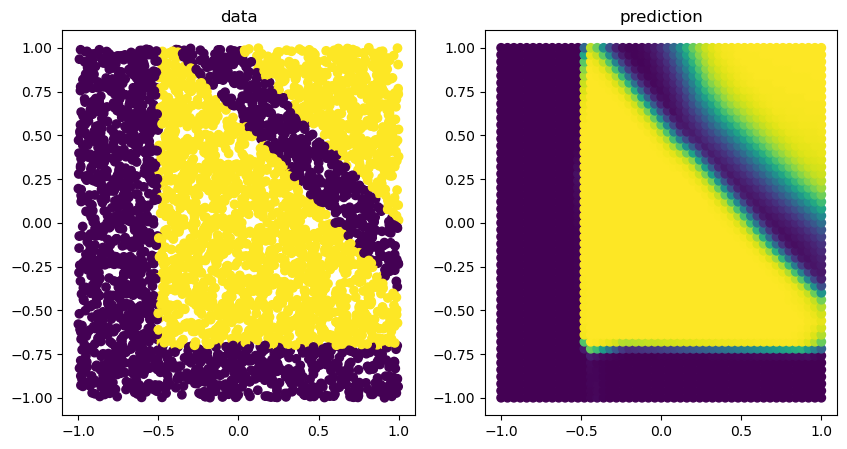

In [130]:
#Predict the possible labels of the grid created previously using the final_model_distribution 1 and plot
pred_optimized = model_1.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated with optimization
axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[1].set_title("prediction")

In [ ]:
# Explain your choice for the variability of this
#shift. Why do not we also augment the validation samples?

# Problem 3 (optional)

### 3.1 Optimization for distribution 2

- Using data from distribution 2, find the best hyperparameters

In [ ]:
#Parameters in DNN 1 does not work well here, rewrite them (increase neurons, batch_sixe and epochs)
batch_size = [30,60,90]
epochs = [500, 1000, 1500]
neurons = [60,90 ,120]

In [ ]:
#create model 
model = KerasClassifier(model=create_model, 
                        batch_size=60,
                       epochs=1500
                          )

#Select which ones will be used in the GridSearchCV
#If batch_size or epochs is commented, then it must be written directly in the KerasClassifier
param_grid = dict(
                  #batch_size = batch_size,
                  #epochs=epochs,
                  optimizer=optimizer,
                  model__activation=activation,
                  #model__dropout_rate=dropout_rate,
                  #layers=layers,
                  model__neurons=neurons
                  #model__init_mode=init_mode
                   )

#n_iter is the number of combinations to be done
#Random grid selects n_iter combinations from the given parameters and test them.
grid_2 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, n_iter=2, cv=3, verbose=1)
grid_result=grid_2.fit(x2,y2)

In [ ]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

#### Test accuracy with distribution 2

In [ ]:
#Split data for distribution 1 in training and validation 
d2_train_data, d2_train_label, d2_val_data, d2_val_label = split_data_training_validation(x2, y2, 0.8)

#Normalize data
d2_train_data=Rescale(d2_train_data)
d2_val_data=Rescale(d2_val_data)

print("Train:",len(d2_train_data),"\t Validation:",len(d2_val_data))

In [ ]:
#Define DNN for distribution 2 using the hyperparameters obtained at the begining 

model_2 = Sequential()
model_2.add(Dense(2,input_shape=(2,), activation='relu'))
model_2.add(Dense(90, activation='sigmoid'))
model_2.add(Dense(90, activation='sigmoid'))   
model_2.add(Dense(90, activation='sigmoid'))
model_2.add(Dropout(0.01))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_2.summary()

In [ ]:
final_model_dsitribution_2= model_2.fit(d2_train_data, d2_train_label, 
               epochs = 1500, batch_size = 60,
               validation_data=(d2_val_data, d2_val_label),
               verbose=2)

In [ ]:
#Predict the possible labels of the grid created previously using the final_model_distribution 2 and plot
pred_optimized_2 = model_2.predict(grid_r)
fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x2[:,0],x2[:,1],c=y2)
axis[0].set_title("data")

#Generated data without optimization

axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized_2)
axis[1].set_title("prediction")